## 7. Get maps of stellar population properties 

Once we have performed SED fitting to all spatial bins in the galaxy, we can construct maps of properties from the collection of those fitting results (in FITS files). For this, we can use `maps_parameters` function in the `piXedfit_fitting` module. Please see the API reference [here](https://pixedfit.readthedocs.io/en/latest/piXedfit_fitting.html#piXedfit.piXedfit_fitting.maps_parameters) for more information about this function. 

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

### 7.1. Construct the maps of properties

Shown below is an example of script for constructing maps of parameters from the fitting results of spatial bins.

In [ ]:
from piXedfit.piXedfit_fitting import maps_parameters

fits_binmap = "pixbin_fluxmap_m51.fits"
hdu = fits.open(fits_binmap)
nbins = int(hdu[0].header['NBINS'])
hdu.close()

bin_ids = []
name_sampler_fits = []
for ii in range(0,nbins):
    bin_ids.append(ii)
    name = "mcmc_bin%d.fits" % (ii+1)
    name_sampler_fits.append(name)

fits_fluxmap = "fluxmap_m51.fits"
name_out_fits = "maps_properties.fits"
maps_parameters(fits_binmap=fits_binmap, bin_ids=bin_ids, name_sampler_fits=name_sampler_fits,
                fits_fluxmap=fits_fluxmap,refband_SFR=18, refband_SM=9, refband_Mdust=20, name_out_fits=name_out_fits)

### 7.2. Check the result: maps of properties

In [2]:
maps = fits.open("maps_properties.fits")
maps.info()

# get the galaxy's region
gal_region = maps['galaxy_region'].data

Filename: maps_properties.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  GALAXY_REGION    1 ImageHDU         8   (141, 141)   float64   
  2  BIN-LOGZSOL-P16    1 ImageHDU         8   (141, 141)   float64   
  3  BIN-LOGZSOL-P50    1 ImageHDU         8   (141, 141)   float64   
  4  BIN-LOGZSOL-P84    1 ImageHDU         8   (141, 141)   float64   
  5  BIN-LOG_TAU-P16    1 ImageHDU         8   (141, 141)   float64   
  6  BIN-LOG_TAU-P50    1 ImageHDU         8   (141, 141)   float64   
  7  BIN-LOG_TAU-P84    1 ImageHDU         8   (141, 141)   float64   
  8  BIN-LOG_ALPHA-P16    1 ImageHDU         8   (141, 141)   float64   
  9  BIN-LOG_ALPHA-P50    1 ImageHDU         8   (141, 141)   float64   
 10  BIN-LOG_ALPHA-P84    1 ImageHDU         8   (141, 141)   float64   
 11  BIN-LOG_BETA-P16    1 ImageHDU         8   (141, 141)   float64   
 12  BIN-LOG_BETA-P50    1 ImageHDU         8   (141, 141)   float64  

In [3]:
# calculate physical size of a single pixel
from piXedfit.piXedfit_images import kpc_per_pixel

z = float(maps[0].header['gal_z'])
arcsec_per_pixel = 8.0                           # pixel size in arcsec; SPIRE VNGS image 
kpc_per_pix = kpc_per_pixel(z,arcsec_per_pixel)
print ("kpc/pixel = %lf" % kpc_per_pix)

kpc/pixel = 0.255985


In [7]:
rows, cols = np.where(gal_region == 0) # get pixels outside the galaxy's region of interest

# stellar mass surface density
map_prop_SM = np.log10(np.power(10.0,maps['pix-log_mass-p50'].data)/kpc_per_pix/kpc_per_pix)
map_prop_SM[rows,cols] = float('nan') 

# dust mass surface density
map_prop_Mdust = np.log10(np.power(10.0,maps['pix-log_dustmass-p50'].data)/kpc_per_pix/kpc_per_pix)
map_prop_Mdust[rows,cols] = float('nan') 

# surface density of SFR
map_SFR = np.log10(np.power(10.0,maps['pix-log_sfr-p50'].data)/kpc_per_pix/kpc_per_pix)
map_SFR[rows,cols] = float('nan') 

# Av dust attenuation
map_Av = 1.086*maps['bin-dust2-p50'].data
map_Av[rows,cols] = float('nan')

# stellar metallicity
map_logzsol  = maps['bin-logzsol-p50'].data
map_logzsol[rows,cols] = float('nan') 

# Mass-weighted age
map_mw_age  = np.power(10.0,maps['bin-log_mw_age-p50'].data)
map_mw_age[rows,cols] = float('nan') 

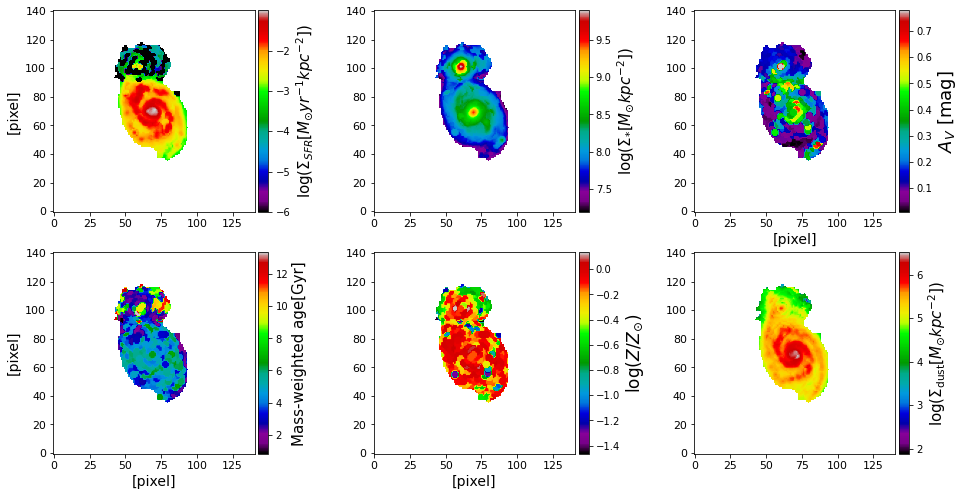

In [9]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig1 = plt.figure(figsize=(14,7))

###=> SFR surface density
f1 = fig1.add_subplot(2, 3, 1)
plt.ylabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_SFR, origin='lower', cmap='nipy_spectral', vmin=-6.0)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($\Sigma_{SFR}[M_{\odot}yr^{-1}kpc^{-2}]$)', fontsize=15)


###=> stellar mass surface density
f1 = fig1.add_subplot(2, 3, 2)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_prop_SM, origin='lower', cmap='nipy_spectral')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($\Sigma_{*}[M_{\odot}kpc^{-2}]$)', fontsize=15)

###=> AV dust attenuation
f1 = fig1.add_subplot(2, 3, 3)
plt.xlabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_Av, origin='lower', cmap='nipy_spectral')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'$A_{V}$ [mag]', fontsize=18)

### mass-weighted age
f1 = fig1.add_subplot(2, 3, 4)
plt.xlabel('[pixel]', fontsize=14)
plt.ylabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_mw_age, origin='lower', cmap='nipy_spectral')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label('Mass-weighted age[Gyr]', fontsize=15)

### stellar metallicity
f1 = fig1.add_subplot(2, 3, 5)
plt.xlabel('[pixel]', fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_logzsol, origin='lower', cmap='nipy_spectral')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($Z/Z_{\odot}$)', fontsize=17)

###=> stellar mass surface density
f1 = fig1.add_subplot(2, 3, 6)
plt.setp(f1.get_xticklabels(), fontsize=11)
plt.setp(f1.get_yticklabels(), fontsize=11)

plt.imshow(map_prop_Mdust, origin='lower', cmap='nipy_spectral')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(r'log($\Sigma_{\rm dust}[M_{\odot}kpc^{-2}]$)', fontsize=15)


plt.subplots_adjust(left=0.07, right=0.95, bottom=0.1, top=0.98, hspace=0.2, wspace=0.3)
plt.show()